# Import Data

In [1]:
# helper.py
from helper import *

In [2]:
# load data
df = pd.read_csv('./data/clean/features.csv')

# check
df.shape, len(set(df.player))

((1099, 310), 237)

- Over 1000 QB seasons for training and validation.
- 306 features (excluding player name, team, year, and target).
- 227 unique QBs.

# Optimize XGBoost

In [3]:
# non-feature cols
non_feat_cols = ['player', 'team_name', 'year', 'target']

# define X and y
X = df.drop(columns=non_feat_cols)
y = df['target']

In [4]:
# define the parameter search space
param_bounds = {
    'max_depth': (1, 10),
    'learning_rate': (0.001, 0.1),
    'gamma': (0, 1),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# run bayesian optimization
optimizer = BayesianOptimization(f=lambda max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree: 
            xgb_cv(max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, X, y),
            pbounds=param_bounds,
            random_state=SEED,
            verbose=2)

# optimize for 110 iterations
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -12.22    | 0.5052    | 0.5019    | 0.05008   | 2.204     | 2.279     | 0.6093    |
| 2         | -12.68    | 0.7093    | 0.2481    | 0.009322  | 4.109     | 2.501     | 0.9393    |
| 3         | -12.63    | 0.9755    | 0.03875   | 0.07021   | 6.155     | 9.082     | 0.8334    |
| 4         | -12.5     | 0.7739    | 0.7024    | 0.03926   | 7.25      | 8.424     | 0.7328    |
| 5         | -12.55    | 0.9703    | 0.8037    | 0.09835   | 2.527     | 5.69      | 0.9728    |
| 6         | -12.49    | 0.8248    | 0.8608    | 0.09711   | 2.67      | 3.188     | 0.9367    |
| 7         | -12.45    | 0.9531    | 0.7583    | 0.03534   | 5.172     | 6.495     | 0.7481    |
| 8         | -12.39    | 0.739     | 0.4356    | 0.08717   | 2.686     | 7.189     | 0.8518    |
| 9         | -12.61

In [5]:
# get best parameters
best_params = optimizer.max['params']
best_params

{'colsample_bytree': 0.5051870769428499,
 'gamma': 0.5018745921487388,
 'learning_rate': 0.050081556020280464,
 'max_depth': 2.2044657606334894,
 'min_child_weight': 2.278999769090847,
 'subsample': 0.6092793378130391}

In [6]:
# get best parameters
best_params = {'colsample_bytree': 0.5051870769428499,
 'gamma': 0.5018745921487388,
 'learning_rate': 0.050081556020280464,
 'max_depth': 2,
 'min_child_weight': 2,
 'subsample': 0.6092793378130391, 
 'n_estimators': 100}

# define model
xgb = XGBRegressor(**best_params, random_state=SEED, n_jobs=-1)

# Predict on 2024
Here we will train on the 2006-2022 data and then use the 2023 data as the holdout test set to predict the 2024 grades.

In [7]:
# define training data (before 2023) and test data (2023)
X_train = df.query('year < 2023').drop(columns=non_feat_cols)
y_train = df.query('year < 2023')['target']
X_test = df.query('year == 2023').drop(columns=non_feat_cols)
y_test = df.query('year == 2023')['target']

# train model
xgb.fit(X_train, y_train)

# make predictions
y_pred = xgb.predict(X_test)

# evaluate model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.4f}')
print(f'R2: {r2:.4f}')

RMSE: 11.4856
R2: 0.3566


- The best model resulted with a RMSE of 11.49 and a r2 0.36 when predicting on the holdout set (2024).

In [8]:
# create a df for our predictions
preds_df = pd.DataFrame(data={'player': df.query('year == 2023')['player'].values, 'team': df.query('year == 2023')['team_name'].values, 
                              'y_true': y_test, 'y_pred': y_pred, 'error': (y_pred - y_test)})

# map colors to our preds_df
preds_df['color'] = preds_df['team'].map(TEAM_COLORS)

# show predictions for all QBs
preds_df.sort_values('error')[['player', 'y_true', 'y_pred', 'error']].T

,684,944,518,836,990,465,69,165,658,652,24,1087,590,672,327,557,309,534,425,647,514,350,1069,151,1088,586,473,699,59,846,604,549,58,176,670,897,456,1050,25,1006,382,626,412,792,356,1095,289,583,444,1030,1064,266,816,809,299,63,364,358,207,946
player,Marcus Mariota,Sam Darnold,Joe Burrow,Nick Mullens,Taylor Heinicke,Jameis Winston,Baker Mayfield,Bryce Young,Lamar Jackson,Kyler Murray,Aaron Rodgers,Tyrod Taylor,Justin Herbert,Malik Willis,Davis Mills,Josh Allen,Daniel Jones,Joe Flacco,Geno Smith,Kyle Trask,Jimmy Garoppolo,Derek Carr,Tyler Huntley,Brock Purdy,Tyson Bagent,Justin Fields,Jared Goff,Mason Rudolph,Anthony Richardson,Patrick Mahomes,Kenny Pickett,Jordan Love,Andy Dalton,C.J. Stroud,Mac Jones,Russell Wilson,Jalen Hurts,Trevor Lawrence,Aidan O'Connell,Tim Boyle,Drew Lock,Kirk Cousins,Gardner Minshew,Matthew Stafford,Deshaun Watson,Will Levis,Cooper Rush,Joshua Dobbs,Jacoby Brissett,Tommy DeVito,Tua Tagovailoa,Clayton Tune,Mitch Trubisky,Mike White,Dak Prescott,Bailey Zappe,Dorian Thompson-Robinson,Desmond Ridder,Carson Wentz,Sam Howell
y_true,88.9,82.7,93.9,76.1,74.7,73.8,86.0,74.4,94.0,82.0,77.8,74.5,91.7,70.3,68.5,91.8,72.0,71.6,82.5,63.8,70.8,85.6,67.6,82.4,64.4,71.5,81.8,62.5,62.2,85.8,65.4,77.7,68.1,78.9,65.0,77.5,76.3,76.8,61.2,54.8,53.6,74.3,60.7,74.7,63.1,54.9,52.9,56.7,59.1,51.3,70.2,45.6,50.4,45.8,67.9,41.0,45.3,45.7,50.7,27.0
y_pred,61.693802,58.817688,75.272446,57.700413,57.348446,58.461433,71.011169,60.730091,80.504715,68.838486,65.710747,63.418732,80.645874,59.266426,58.006111,82.922089,63.36816,63.461617,74.48867,56.218708,63.403599,78.485878,61.851318,78.251541,60.391735,67.868927,78.542412,59.949764,60.957703,84.585266,64.349434,77.087067,67.515839,78.318123,64.421333,76.946754,76.748558,77.717644,63.703026,57.667606,57.941982,79.29525,65.763344,79.857552,69.144005,61.123898,59.359905,64.297768,67.07177,60.587982,79.568207,55.109417,60.022713,59.080708,81.741943,54.955036,59.532616,61.16431,67.741028,64.97625
error,-27.206198,-23.882312,-18.627554,-18.399587,-17.351554,-15.338567,-14.988831,-13.669909,-13.495285,-13.161514,-12.089253,-11.081268,-11.054126,-11.033574,-10.493889,-8.877911,-8.63184,-8.138383,-8.01133,-7.581292,-7.396401,-7.114122,-5.748682,-4.148459,-4.008265,-3.631073,-3.257588,-2.550236,-1.242297,-1.214734,-1.050566,-0.612933,-0.584161,-0.581877,-0.578667,-0.553246,0.448558,0.917644,2.503026,2.867606,4.341982,4.99525,5.063344,5.157552,6.044005,6.223898,6.459905,7.597768,7.97177,9.287982,9.368207,9.509417,9.622713,13.280708,13.841943,13.955036,14.232616,15.46431,17.041028,37.97625


In [9]:
# percent of preds within 10 pts
percent = (preds_df.error.abs() < 10).sum() / len(preds_df)

print(f'{percent*100:.1f}% of our model\'s predictions are within 10 pts of the true value.')

63.3% of our model's predictions are within 10 pts of the true value.


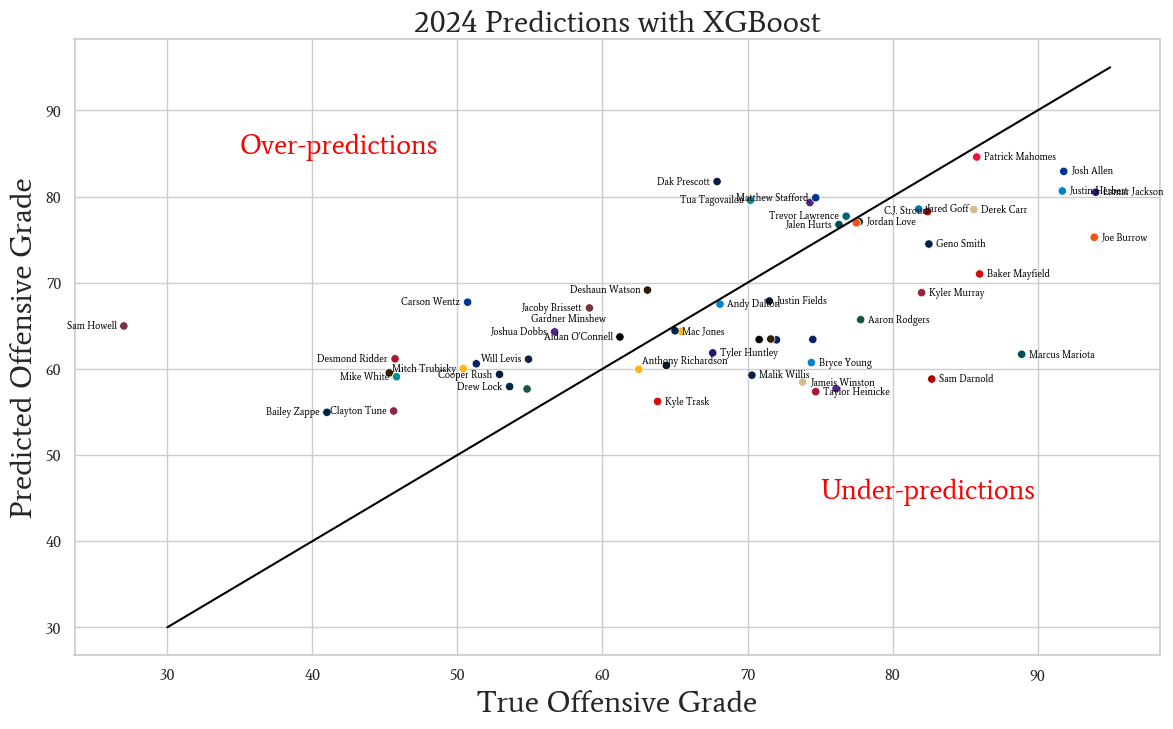

In [25]:
# visualize predictions
plt.figure(figsize=(14, 8))

# lists for annotating player names
over_drops = ['Tim Boyle', 'Tommy DeVito', 'Dorian Thompson-Robinson', 'Kirk Cousins']
under_drops = ['Nick Mullens', 'Mason Rudolph', 'Brock Purdy', 'Tyson Bagent', 
               'Davis Mills', 'Tyrod Taylor', 'Jimmy Garoppolo', 'Daniel Jones', 'Russell Wilson', 'Kenny Pickett', 'Joe Flacco']

# title, labels
plt.title('2024 Predictions with XGBoost', fontsize=22)
plt.xlabel('True Offensive Grade', fontsize=22)
plt.ylabel('Predicted Offensive Grade', fontsize=22)

# team colors
color_palette = {color: color for color in preds_df['color'].unique()}

# plot players as points
sns.scatterplot(data=preds_df, x='y_true', y='y_pred', hue='color', palette=color_palette, legend=False)

# plot line to show perfect predictions
sns.lineplot(x=range(30,96), y=range(30,96), color='black')

# annotating each point with the player's name
for index, row in preds_df.iterrows():
    # over preds (above line)
    if (row['y_pred'] > row['y_true']) and (row['player'] not in over_drops):
        plt.text(row['y_true']-0.5, row['y_pred']-0.3, row['player'], horizontalalignment='right', color='black', 
             weight='semibold', fontsize=7)
    # under preds (below line)
    elif (row['y_pred'] < row['y_true']) and (row['player'] not in under_drops):
        plt.text(row['y_true']+0.5, row['y_pred']-0.3, row['player'], horizontalalignment='left', color='black', 
             weight='semibold', fontsize=7)
        
# annotate "Over-predictions" and "Under-predictions"
plt.text(35, 85, 'Over-predictions', fontsize=20, weight='semibold', color='red')
plt.text(75, 45, 'Under-predictions', fontsize=20, weight='semibold', color='red')
plt.show()

- Each point represents a single player in 2024.
- The distance from the black line is how far off our prediction was. Ideally, a perfect model would only have dots on the line. 
- Dots above the line are cases in which our model overpredictions, and dots below the line are underpredictions.

# 2025 Predictions

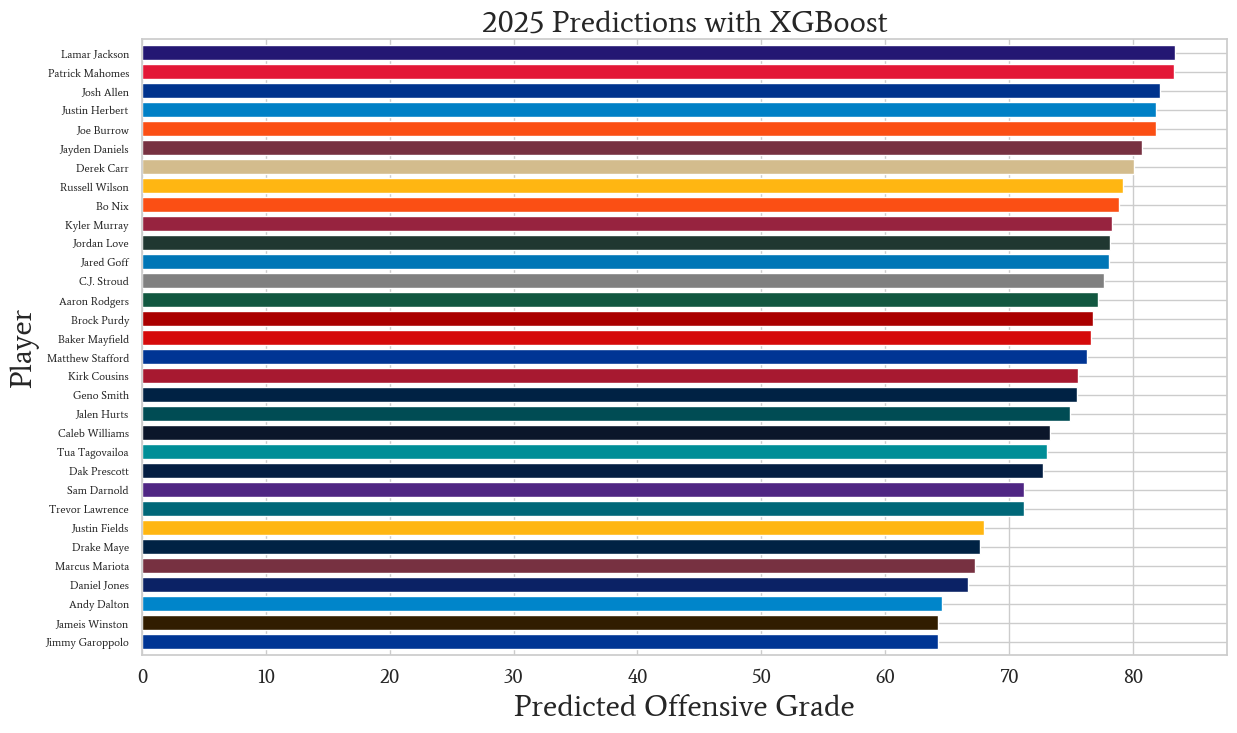

In [40]:
# load 2024 data
df_2024 = pd.read_csv('./data/clean/features_2024.csv')

# fit model on all data
xgb.fit(X, y)

# make predictions on 2024 data
y_pred_2024 = xgb.predict(df_2024.drop(columns=non_feat_cols))

# create a df for our predictions
preds_2024_df = pd.DataFrame(data={'player': df_2024['player'].values, 'team': df_2024['team_name'].values, 
                                   'y_pred': y_pred_2024}).sort_values('y_pred')

# map colors
preds_2024_df['color'] = preds_2024_df['team'].map(TEAM_COLORS).fillna('gray')

# get top 32
top_32 = preds_2024_df.tail(32)

# barplot of preds
plt.figure(figsize=(14, 8))
plt.title('2025 Predictions with XGBoost', fontsize=22)
plt.xlabel('Predicted Offensive Grade', fontsize=22)
plt.ylabel('Player', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=8)
plt.barh(top_32['player'], top_32['y_pred'], color=top_32['color'])
plt.margins(y=0.01)
plt.show()